# Santander Customer Transaction Prediction

**this notebook performs the main steps for creating a model for the [Santander Customer Transaction Prediction](https://www.kaggle.com/competitions/santander-customer-transaction-prediction/overview) competition**

---

## Workflow Overview

1. **Import Libraries** - load required python libraries and configure the environment
2. **Load Data** - read the raw training and test datasets from csv files
3. **EDA**
4. **Low-Variance Feature Removal** - identify and drop features with very low variance
5. **Making Pipeline** - build preprocessing pipeline with imputer and transformers
6. **Model Training & Optimization** - train LightGBM model and optimize hyperparameters with Optuna
7. **Save Model** - Save the final model with pipeline using joblib

<div style="background-color: #fffbe6; border-left: 4px solid #c8a800; padding: 10px; border-radius: 4px;"><h4>Loading Necessary Libraries</h4></div>

In [72]:
!pip install Optuna

import pandas as pd 
import numpy as np
from IPython.display import display, HTML

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
import optuna
import warnings
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.calibration import calibration_curve 

<div style="background-color: #fffbe6; border-left: 4px solid #c8a800; padding: 10px; border-radius: 4px;"><h4>Loading the Data</h4></div>

In [38]:
train_data = pd.read_csv('/home/jovyan/work/Santander Customer Transaction Prediction/data/train.csv')
train_data

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [39]:
test_data = pd.read_csv('/home/jovyan/work/Santander Customer Transaction Prediction/data/test.csv')
test_data

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,test_199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,...,2.0544,9.6849,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801
199996,test_199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,...,5.0071,6.6548,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689
199997,test_199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,...,5.1536,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762
199998,test_199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,...,3.4259,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122


In [40]:
train_data_ids = train_data['ID_code'].copy()
test_data_ids = test_data['ID_code'].copy()

train_data.drop(columns='ID_code', inplace=True)
test_data.drop(columns='ID_code', inplace=True)

<div style="background-color: #fffbe6; border-left: 4px solid #c8a800; padding: 10px; border-radius: 4px;"><h4>EDA</h4></div>

In [41]:
# checking if the columns on train and test data are same 

tr_cols = set(train_data.columns)
ts_cols = set(test_data.columns)

if tr_cols == ts_cols:
    print('columns are the same')
else:
    only_in_train = tr_cols - ts_cols
    only_in_test = ts_cols - tr_cols
    print('only in train data - ', only_in_train)
    print('only in test data - ', only_in_test)

# conclusion - only target columns is the diffrecne, but it's okay

only in train data -  {'target'}
only in test data -  set()


In [42]:
print(f'train_data shape - {train_data.shape}')
print(f'test_data shape - {test_data.shape}\n')

print(f'columns with null value in train_data - {train_data.isna().sum()[train_data.isna().sum() > 0]}')
print(f'columns with null value in test_data - {test_data.isna().sum()[test_data.isna().sum() > 0]}')

train_data shape - (200000, 201)
test_data shape - (200000, 200)

columns with null value in train_data - Series([], dtype: int64)
columns with null value in test_data - Series([], dtype: int64)


,proportion
target,
0,89.95%
1,10.05%


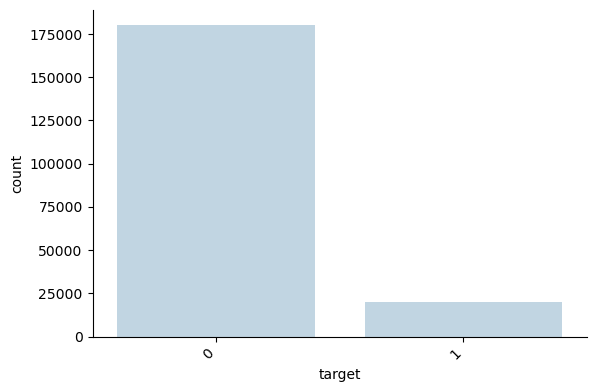

In [43]:
# the share of targer
display(
    train_data['target'].value_counts(normalize=True)
    .to_frame()
    .style.background_gradient(cmap='Set3')
    .format("{:.2%}")
)

g = sns.catplot(
    data=train_data,
    x="target",
    aspect=1.5,
    height=4,
    alpha=0.3,
    kind="count",
).set_xticklabels(rotation=45, horizontalalignment="right")

In [44]:
# identifying categorial and numeric cols

train_cat_cols = list(train_data.select_dtypes(include='object').columns)
train_num_cols = list(train_data.select_dtypes(include=np.number).columns.difference(['target']))

test_cat_cols = list(test_data.select_dtypes(include='object').columns)
test_num_cols = list(test_data.select_dtypes(include=np.number).columns.difference(['target']))

<div style="background-color: #fffbe6; border-left: 4px solid #c8a800; padding: 10px; border-radius: 4px;"><h4>Identifying and Dropping Low-Variance Features</h4></div>

In [45]:
corr = train_data.corr(numeric_only=True).abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# find highly correlated features(>0.95)
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f'highly correlated features to drop - {to_drop}') 

highly correlated features to drop - []


In [46]:
train_data.drop(columns=to_drop, inplace=True)
test_data.drop(columns=to_drop, inplace=True)
print(f'after dropping highly correlated features \n\ttrain_shape - {train_data.shape} \n\ttest_data shape - {test_data.shape}')

after dropping highly correlated features 
	train_shape - (200000, 201) 
	test_data shape - (200000, 200)


In [47]:
def feature_usefulness_report(df, target_col, categorical_cols, skew_thresh=0.98):
    results = []

    if not categorical_cols:
        return pd.DataFrame()
    
    for col in categorical_cols:
        s = df[col]
        n_unique = s.nunique(dropna=False)
        value_counts = s.value_counts(dropna=False)
        top_ratio = value_counts.iloc[0] / len(s)

        # Target concentration per value
        target_mean_by_value = df.groupby(col)[target_col].mean()
        target_std = target_mean_by_value.std(ddof=0)
        target_diff = target_mean_by_value.max() - target_mean_by_value.min()

        # Heuristics
        if n_unique == 1:
            verdict = "drop"
            reason = "constant feature"
        elif top_ratio > skew_thresh:
            if target_diff < 0.02:
                verdict = "drop"
                reason = f"super-skewed ({top_ratio:.2%} same value) with no target variation"
            else:
                verdict = "maybe useful"
                reason = f"super-skewed ({top_ratio:.2%}) but small target difference ({target_diff:.2%})"
        elif n_unique < 3:
            if target_diff < 0.02:
                verdict = "drop"
                reason = f"only {n_unique} unique values and no target variation"
            else:
                verdict = "keep"
                reason = f"binary/ternary variable with target difference ({target_diff:.2%})"
        elif value_counts.iloc[1:].sum() < 0.01 * len(s):
            verdict = "drop"
            reason = f"rare categories dominate, only top value has coverage"
        elif target_std < 0.001:
            verdict = "drop"
            reason = "no variation in target concentration across values"
        else:
            verdict = "keep"
            reason = f"reasonable distribution (top value {top_ratio:.2%}), target difference {target_diff:.2%}"

        results.append({
            "feature": col,
            "n_unique": n_unique,
            "top_value_ratio": round(top_ratio, 4),
            "target_diff": round(target_diff, 4),
            "verdict": verdict,
            "reason": reason
        })

    return pd.DataFrame(results).sort_values("verdict", ascending=True)

In [48]:
report_df = feature_usefulness_report(train_data, target_col='target', categorical_cols=train_cat_cols)

if report_df is None or report_df.empty:
    print("skipping - no categorical columns")
else:
    display(report_df)
    display(HTML(report_df.to_html(index=False)))
    summary_of_report_df = report_df.groupby("verdict").agg(
        count=("feature", "count")
        , n_unique=("n_unique", "sum")
        , top_value_ratio=("top_value_ratio", "mean")
        , target_diff=("target_diff", "mean")
    )
    display(summary_of_report_df)

skipping - no categorical columns


<div style="background-color: #fffbe6; border-left: 4px solid #c8a800; padding: 10px; border-radius: 4px;"><h4>Making Pipeline</h4></div>

In [49]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, train_num_cols),
    ("cat", cat_transformer, train_cat_cols)
])

lgbm = LGBMClassifier(random_state=42, verbose=-1)
pipe = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", lgbm)
])

<div style="background-color: #fffbe6; border-left: 4px solid #c8a800; padding: 10px; border-radius: 4px;"><h4>Model Training & Hyperparameter Optimization with Optuna</h4></div>

In [50]:
y = train_data['target']
X = train_data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [33]:
# silence Optuna + warnings 
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

pos_weight = (y == 0).sum() / (y == 1).sum()


# objective function Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500, step=300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 50, step=5),
        "max_depth": trial.suggest_categorical("max_depth", [4, 6, 8, 10]),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 300, step=50),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0, step=0.1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0, step=0.1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 10.0, log=True),
        "scale_pos_weight": pos_weight,
        "objective": "binary",
        "boosting_type": "gbdt",
        # "n_jobs": -1, # using all processors
        "verbose": -1
    }

    pipe.set_params(**{f"clf__{k}": v for k, v in params.items()})

    # stratified 5-fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # compute mean ROC-AUC
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    mean_score = np.mean(scores)

    # controlled verbosity - print every 10th trial
    if (trial.number + 1) % 10 == 0:
        best_so_far = trial.study.best_value if trial.study.best_value is not None else mean_score
        print(f"[Trial {trial.number + 1:03}] mean ROC-AUC: {mean_score:.5f} | best so far: {best_so_far:.5f}")

    return mean_score

In [ ]:
# create or load Optuna study
study = optuna.create_study(
    direction="maximize",
    study_name="LGBM_AUC",
    storage="sqlite:///lgbm_with_optuna.db",
    load_if_exists=True
)

# run optimization
study.optimize(objective, n_trials=10, n_jobs=1, show_progress_bar=True)

# final results
print("\n=== OPTIMIZATION COMPLETE ===")
print(f"best CV ROC AUC: {study.best_value:.5f}")
print("best params:", study.best_params)

# visualizations
display(optuna.visualization.plot_param_importances(study))
display(optuna.visualization.plot_optimization_history(study))

Best trial: 2. Best value: 0.890957:  10%|█         | 1/10 [40:21<6:03:11, 2421.33s/it]

<div style="background-color: #fffbe6; border-left: 4px solid #c8a800; padding: 10px; border-radius: 4px;"><h4>train the model</h4></div>

In [51]:
# retrain best model on full training data with best parameters 
lgbm_best_params = {f"clf__{k}": v for k, v in study.best_params.items()}
pipe.set_params(**lgbm_best_params)
lgbm_best_model = pipe.fit(X_train, y_train)

<div style="background-color: #fffbe6; border-left: 4px solid #c8a800; padding: 10px; border-radius: 4px;"><h4>Saving the Best Model</h4></div>

In [55]:
import joblib

joblib.dump(lgbm_best_model, 'lgbm_best_model.joblib')

['lgbm_best_model.joblib']

<div style="background-color: #fffbe6; border-left: 4px solid #c8a800; padding: 10px; border-radius: 4px;"><h4>Evaluate on Validation Data</h4></div>

In [57]:
y_pred = lgbm_best_model.predict(X_test)
y_proba = lgbm_best_model.predict_proba(X_test)[:, 1]

print("\nROC AUC:", roc_auc_score(y_test, y_proba))
print("average precision (PR AUC):", average_precision_score(y_test, y_proba))
print("accuracy:", accuracy_score(y_test, y_pred))
print("\nclassification Report:\n", classification_report(y_test, y_pred, digits=3))


ROC AUC: 0.8930177627703617
average precision (PR AUC): 0.5882983337782653
accuracy: 0.92015

classification Report:
               precision    recall  f1-score   support

           0      0.925     0.992     0.957     35980
           1      0.788     0.281     0.415      4020

    accuracy                          0.920     40000
   macro avg      0.856     0.636     0.686     40000
weighted avg      0.911     0.920     0.903     40000



<div style="background-color: #fffbe6; border-left: 4px solid #c8a800; padding: 10px; border-radius: 4px;"><h4>Visual Diagnostics</h4><p>Each section below includes a standard visualization for classification model diagnostics.</p></div>

**ROC Curve(true vs false positive rates)**

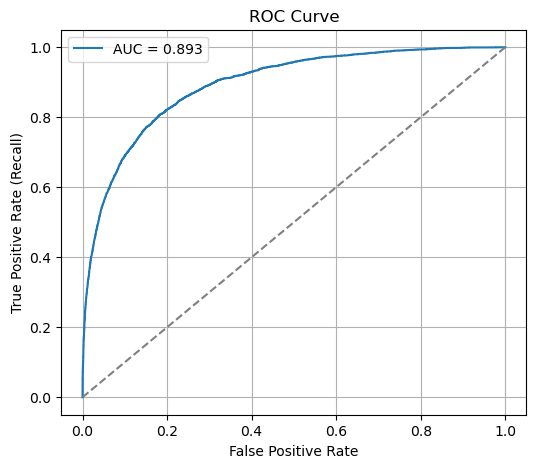

In [61]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

**Precision-Recall Curve**

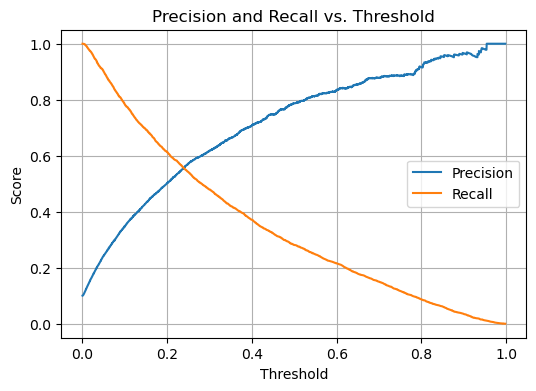

In [65]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [66]:
prec, rec, thres = precision_recall_curve(y_test, y_proba)
f1 = 2 * prec * rec / (prec + rec)
best_idx = f1.argmax()
best_threshold = thres[best_idx]
print(f"best threshold: {best_threshold:.3f} | F1: {f1[best_idx]:.3f}")

y_pred_adj = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_adj))

best threshold: 0.223 | F1: 0.557
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     35980
           1       0.53      0.58      0.56      4020

    accuracy                           0.91     40000
   macro avg       0.74      0.76      0.75     40000
weighted avg       0.91      0.91      0.91     40000



**Feature Importances**

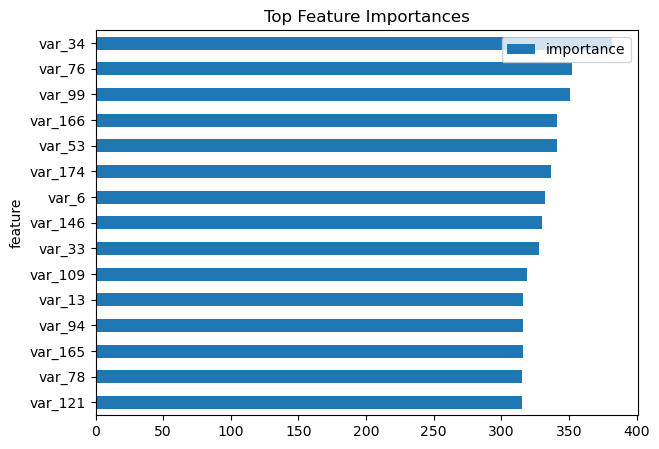

In [70]:
preproc = lgbm_best_model.named_steps["preproc"]
num_names = train_num_cols

try:
    ohe = preproc.named_transformers_["cat"].named_steps["onehot"]
    cat_names = list(ohe.get_feature_names_out(train_cat_cols))
except:
    cat_names = []

feature_names_all = num_names + cat_names

importances = lgbm_best_model.named_steps["clf"].feature_importances_
feat_imp = pd.DataFrame({"feature": feature_names_all, "importance": importances})
feat_imp.sort_values("importance", ascending=False, inplace=True)
feat_imp.head(15).plot.barh(x="feature", y="importance", figsize=(7,5), title="Top Feature Importances")
plt.gca().invert_yaxis()
plt.show()

**Calibration (Reliability) Plot**

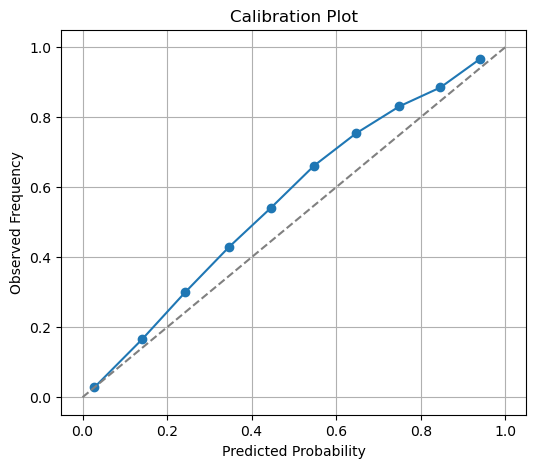

In [73]:
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, "o-")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Plot")
plt.grid(True)
plt.show()